In [28]:
import warnings
warnings.simplefilter('ignore')

import gc

import time
import datetime

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
pd.set_option('max_columns', 100)
pd.set_option('max_rows', 100)
from tqdm.notebook import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

import lightgbm as lgb

In [2]:
train = pd.read_csv('train.csv')
train = train.sort_values(by=['QUEUE_ID', 'DOTTING_TIME']).reset_index(drop=True)

test = pd.read_csv('evaluation_public.csv')
test = test.sort_values(by=['ID', 'DOTTING_TIME']).reset_index(drop=True)

In [3]:
train.head()

,QUEUE_ID,CU,STATUS,QUEUE_TYPE,PLATFORM,CPU_USAGE,MEM_USAGE,LAUNCHING_JOB_NUMS,RUNNING_JOB_NUMS,SUCCEED_JOB_NUMS,CANCELLED_JOB_NUMS,FAILED_JOB_NUMS,DOTTING_TIME,RESOURCE_TYPE,DISK_USAGE
0,2,16,available,sql,x86_64,3,54,0,0,0,0,0,1590683100000,vm,20.0
1,2,16,available,sql,x86_64,2,54,0,0,0,0,0,1590683400000,vm,20.0
2,2,16,available,sql,x86_64,7,54,0,0,0,0,0,1590683700000,vm,20.0
3,2,16,available,sql,x86_64,4,54,0,0,0,0,0,1590684000000,vm,20.0
4,2,16,available,sql,x86_64,5,54,0,0,0,0,0,1590684120000,vm,20.0


In [4]:
test.head()

,ID,QUEUE_ID,CU,STATUS,QUEUE_TYPE,PLATFORM,CPU_USAGE,MEM_USAGE,LAUNCHING_JOB_NUMS,RUNNING_JOB_NUMS,SUCCEED_JOB_NUMS,CANCELLED_JOB_NUMS,FAILED_JOB_NUMS,DOTTING_TIME,RESOURCE_TYPE,DISK_USAGE
0,1,297,16,available,sql,x86_64,60,69,0,5,5,0,0,1662213420000,vm,9
1,1,297,16,available,sql,x86_64,58,69,0,9,4,0,0,1662213720000,vm,9
2,1,297,16,available,sql,x86_64,80,67,0,9,1,0,0,1662214020000,vm,9
3,1,297,16,available,sql,x86_64,100,65,0,7,2,0,1,1662214320000,vm,9
4,1,297,16,available,sql,x86_64,98,67,0,10,3,0,1,1662214620000,vm,9


In [5]:
train.shape, test.shape

((501730, 15), (14980, 16))

In [6]:
# 这些 columns 在 test 只有单一值, 所以直接去掉

del train['STATUS']
del train['PLATFORM']
del train['RESOURCE_TYPE']

del test['STATUS']
del test['PLATFORM']
del test['RESOURCE_TYPE']

In [7]:
# Label Encoding

le = LabelEncoder()
train['QUEUE_TYPE'] = le.fit_transform(train['QUEUE_TYPE'].astype(str))
test['QUEUE_TYPE'] = le.transform(test['QUEUE_TYPE'].astype(str))

In [8]:
# 只用 CPU_USAGE 和 MEM_USAGE，CU 及 QUEUE_TYPE （提取）

keep_cols_train = ['QUEUE_ID', 'CU', 'QUEUE_TYPE', 'MEM_USAGE', 'CPU_USAGE', 'LAUNCHING_JOB_NUMS']
keep_cols_test = ['ID', 'QUEUE_ID', 'CU', 'QUEUE_TYPE', 'MEM_USAGE', 'CPU_USAGE', 'LAUNCHING_JOB_NUMS']

train = train[keep_cols_train]
test = test[keep_cols_test]

In [9]:
train.head()

,QUEUE_ID,CU,QUEUE_TYPE,MEM_USAGE,CPU_USAGE,LAUNCHING_JOB_NUMS
0,2,16,2,54,3,0
1,2,16,2,54,2,0
2,2,16,2,54,7,0
3,2,16,2,54,4,0
4,2,16,2,54,5,0


In [10]:
merge_cols = ['MEM_USAGE', 'CPU_USAGE', 'LAUNCHING_JOB_NUMS']

In [11]:
# 处理train

for i in range(1, 6):
    cols = [col + "_" + str(i) for col in merge_cols]
    train[cols] = train.groupby('QUEUE_ID')[merge_cols].shift(-1 * i + 1)
    
for i in range(1, 6):
    cpu_name = 'cpu_' + str(i)
    train[cpu_name] = train.groupby('QUEUE_ID')['CPU_USAGE'].shift(-1 * i - 4)
    
for i in range(1, 6):
    launch_name = 'launch_' + str(i)
    train[launch_name] = train.groupby('QUEUE_ID')['LAUNCHING_JOB_NUMS'].shift(-1 * i - 4)
    
train.drop(columns=merge_cols, inplace=True)

In [12]:
# 处理test

for i in range(1, 6):
    cols = [col + "_" + str(i) for col in merge_cols]
    test[cols] = test.groupby(['ID', 'QUEUE_ID'])[merge_cols].shift(-1 * i + 1)
    
test.drop(columns=merge_cols, inplace=True)

In [13]:
train.head()

,QUEUE_ID,CU,QUEUE_TYPE,MEM_USAGE_1,CPU_USAGE_1,LAUNCHING_JOB_NUMS_1,MEM_USAGE_2,CPU_USAGE_2,LAUNCHING_JOB_NUMS_2,MEM_USAGE_3,CPU_USAGE_3,LAUNCHING_JOB_NUMS_3,MEM_USAGE_4,CPU_USAGE_4,LAUNCHING_JOB_NUMS_4,MEM_USAGE_5,CPU_USAGE_5,LAUNCHING_JOB_NUMS_5,cpu_1,cpu_2,cpu_3,cpu_4,cpu_5,launch_1,launch_2,launch_3,launch_4,launch_5
0,2,16,2,54,3,0,54.0,2.0,0.0,54.0,7.0,0.0,54.0,4.0,0.0,54.0,5.0,0.0,3.0,2.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0
1,2,16,2,54,2,0,54.0,7.0,0.0,54.0,4.0,0.0,54.0,5.0,0.0,55.0,3.0,0.0,2.0,2.0,5.0,6.0,2.0,0.0,0.0,0.0,0.0,0.0
2,2,16,2,54,7,0,54.0,4.0,0.0,54.0,5.0,0.0,55.0,3.0,0.0,54.0,2.0,0.0,2.0,5.0,6.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0
3,2,16,2,54,4,0,54.0,5.0,0.0,55.0,3.0,0.0,54.0,2.0,0.0,54.0,2.0,0.0,5.0,6.0,2.0,3.0,10.0,0.0,0.0,0.0,0.0,1.0
4,2,16,2,54,5,0,55.0,3.0,0.0,54.0,2.0,0.0,54.0,2.0,0.0,54.0,5.0,0.0,6.0,2.0,3.0,10.0,6.0,0.0,0.0,0.0,1.0,1.0


In [19]:
train = train.dropna()
test = test.dropna()

In [20]:
launch_cols = ['LAUNCHING_JOB_NUMS' + "_" + str(i) for i in range(1, 6)]
launch_cols.extend(['launch_' + str(i) for i in range(1, 6)])

In [21]:
df_launch = train[launch_cols]

In [22]:
df_launch.head()

,LAUNCHING_JOB_NUMS_1,LAUNCHING_JOB_NUMS_2,LAUNCHING_JOB_NUMS_3,LAUNCHING_JOB_NUMS_4,LAUNCHING_JOB_NUMS_5,launch_1,launch_2,launch_3,launch_4,launch_5
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [24]:
df_launch.describe()

,LAUNCHING_JOB_NUMS_1,LAUNCHING_JOB_NUMS_2,LAUNCHING_JOB_NUMS_3,LAUNCHING_JOB_NUMS_4,LAUNCHING_JOB_NUMS_5,launch_1,launch_2,launch_3,launch_4,launch_5
count,501343.000000,501343.000000,501343.000000,501343.000000,501343.000000,501343.000000,501343.000000,501343.000000,501343.000000,501343.000000
mean,0.150091,0.150057,0.150037,0.150029,0.150017,0.150011,0.150009,0.150005,0.149999,0.149987
std,2.220551,2.220537,2.220525,2.220521,2.220510,2.220509,2.220509,2.220508,2.220507,2.220500
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000


In [23]:
df_launch.values

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [25]:
df_launch['x_mean'] = df_launch[[f'LAUNCHING_JOB_NUMS_{i}' for i in range(1,6)]].mean(axis=1)
df_launch['y_mean'] = df_launch[[f'launch_{i}' for i in range(1,6)]].mean(axis=1)

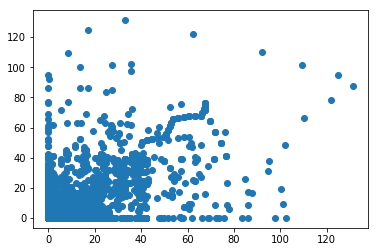

In [29]:
fig, ax = plt.subplots()
ax.scatter(df_launch['x_mean'], df_launch['y_mean'])

In [31]:
df_launch.values[1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [32]:
df_launch.shape

(501343, 12)

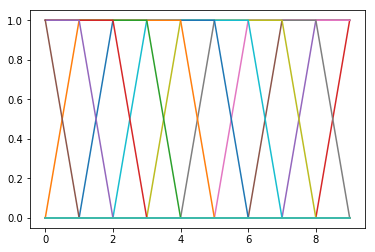

In [34]:
del df_launch['x_mean']
del df_launch['y_mean']

fig, ax = plt.subplots()
for i in range(0, 500):
    ax.plot(list(range(10)), df_launch.values[i])

In [35]:
df_launch_1 = df_launch.loc[~(df_launch==0).all(axis=1)]

In [37]:
df_launch_1.head(100)

,LAUNCHING_JOB_NUMS_1,LAUNCHING_JOB_NUMS_2,LAUNCHING_JOB_NUMS_3,LAUNCHING_JOB_NUMS_4,LAUNCHING_JOB_NUMS_5,launch_1,launch_2,launch_3,launch_4,launch_5
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
5,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
6,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
7,0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
8,0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0
9,0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
10,0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
11,0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
12,1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
